In [ ]:
# Load the necessary packages. 

import numpy as np 
import math
import torch

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import h5py

from torch.utils.data import DataLoader

In [50]:
# internal load 
from unet_2 import UNet_2

In [2]:
# Load the experiment data. 

dir_exp = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-18/17-58/img/'
# dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/mask/'
# dir_D = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/Diffusion/'
# D_range = [0.01, 1]

In [84]:
filename = dir_exp + 'img_1.mat'
file = load_file(filename)

In [86]:
np.shape(file)

(250, 250, 21)

In [ ]:
patch_size = 64
image_size = 250
overlay = 0.2


#ls =  range(0, w ,  math.floor(patch_size * (1 - overlay)))
step = math.floor(patch_size * (1 - overlay))

crop_positions = []
# Calculate crop positions
for start in range(0, image_size - patch_size + 1, step):
    crop_positions.append(start)

# Ensure the last crop aligns with the image edge
if crop_positions[-1] + patch_size < image_size:
    crop_positions.append(image_size - patch_size)

print("Crop positions:", crop_positions)

Crop positions: [0, 51, 102, 153, 186]


In [105]:
print(experiment_loader)


<class '__main__.experiment_loader'>


In [100]:
dataset = experiment_loader(dir_exp)
#loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True) # Multi processing introduces errors
exp_data = DataLoader(dataset,batch_size=1)

for batch in exp_data:
    a = (batch['image'])
    a = a.squeeze(0)   # Reduce the dimension for batch. 
    break 

torch.Size([50, 64, 64, 3])

In [3]:
def load_file(filename):
    ext = filename.split('.')[-1]
    if ext == 'mat':
        try:
            # Try to open with h5py for MATLAB version 7.3+
            
            mat_file = h5py.File(filename, 'r')
            keys = list(mat_file.keys())
            if not keys:
                raise ValueError("No datasets found in the .mat file.")
            dataset_name = keys[0]
            file = mat_file[dataset_name][:].T
            if len(file.shape) == 3:
                file = (file * 255 ).astype(np.uint8)
            return file
        except OSError:
            # If it's not an HDF5 file, fall back to scipy for older versions
            # print(f"{filename} is not an HDF5 file, trying scipy.io.loadmat()")
            mat_file = scipy.io.loadmat(filename)
            keys = list(mat_file.keys())
            # Skip MATLAB-specific meta fields like __header__, __version__, __globals__
            data_keys = [key for key in keys if not key.startswith('__')]
            if not data_keys:
                raise ValueError("No datasets found in the .mat file.")
            dataset_name = data_keys[0]
            return file
        
    # elif ext == 'tif':  # need to add more details on file loading 
        

In [99]:
class experiment_loader():
    def __init__(self, dir_exp:str, patch_size: float = 64, overlap: float = 0.2, channel: float = 3):
        self.dir_exp = Path(dir_exp)
        self.patch_size = patch_size
        self.overlap = overlap
        self.channel = channel
        # self.ids = range(len([file for file in listdir(dir_exp) if isfile(join(dir_exp, file))] ))
        self.filelist = [file for file in listdir(dir_exp) if isfile(join(dir_exp, file))]
        self.idx = range(len(self.filelist))
        if not self.idx:
            raise RuntimeError(f'No input file found in {dir_exp}.')

    def __len__(self):
        return len(self.filelist)
    def __getitem__(self, idx):
        img_file = join(self.dir_exp, self.filelist[idx])
        img = load_file(img_file)  # The returned img is a numpy matrix 

        processed_img = self.preprocess(img, img_file, self.patch_size, self.overlap, self.channel)
        return {'image': torch.as_tensor(processed_img.copy()).float().contiguous(),}

        

    def preprocess(self, img, img_file, patch_size, overlap, channel):
        # Check the size of the image 
        if len(np.shape(img)) == 2:
            w,h = np.shape(img)
            f = 1
        elif len(np.shape(img)) == 3:
            w,h,f = np.shape(img)

        else: 
            raise RuntimeError(f'Check the input file dimensions: {img_file}.')

        # Crop it into smaller pieces, for model input.
        # First check if the img is too small.  

        if (w < patch_size) | (h < patch_size): 
            raise ValueError(f'The image file is too small. At least {patch_size} pixels of width and height: \n {img_file}')
        

        # Start to crop 
        step_size = math.floor(patch_size * (1 - overlap))    # The steps with the overlay included.
        # initiate the x y cropping index
        x_ind = []
        y_ind = []

        # crop in x: 
        for start in range(0, w - patch_size + 1, step_size):
            x_ind.append(start)

        # Take care of the edge: 
        if (x_ind[-1] + patch_size ) < w:
            x_ind.append(w - patch_size)


        # crop in y: 
        for start in range(0, h - patch_size + 1, step_size):
            y_ind.append(start)

        if (y_ind[-1] + patch_size ) < h:
            y_ind.append(h - patch_size)

        # devide in frames, same as xy but no overlay:
        f_ind = []

        for start in range(0, f - channel + 1, channel ):
            f_ind.append(start)
        if (f_ind[-1] + channel ) < f: 
            f_ind.append(f - channel)

        # Construct the cropped images as input: 
        index = 0
        l = len(x_ind) * len(y_ind) * len(f_ind)
        img_array = np.zeros([l,channel, patch_size, patch_size])
        for xi, i in enumerate(x_ind):
            for yj, j in enumerate(y_ind):
                for fk, k in enumerate(f_ind): 
                    # Crop the frame correctly
                    frame = img[i:i + patch_size, j:j + patch_size, k:k + channel]
                    frame = (frame - np.min(frame))/(np.max(frame) -  np.min(frame))
                    frame = np.transpose(frame , (2,0,1)) # Reorder from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    img_array[index] = frame
                    index += 1
        return img_array


    

In [ ]:


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    elif ext == '.mat':
        try:
            # Try to open with h5py for MATLAB version 7.3+
            
            mat_file = h5py.File(filename, 'r')
            keys = list(mat_file.keys())
            if not keys:
                raise ValueError("No datasets found in the .mat file.")
            dataset_name = keys[0]
            file = mat_file[dataset_name][:].T
            if len(file.shape) == 3:
                file = (file * 255 ).astype(np.uint8)
            imgfile = Image.fromarray(file)  
            return imgfile
        except OSError:
            # If it's not an HDF5 file, fall back to scipy for older versions
            # print(f"{filename} is not an HDF5 file, trying scipy.io.loadmat()")
            mat_file = scipy.io.loadmat(filename)
            keys = list(mat_file.keys())
            # Skip MATLAB-specific meta fields like __header__, __version__, __globals__
            data_keys = [key for key in keys if not key.startswith('__')]
            if not data_keys:
                raise ValueError("No datasets found in the .mat file.")
            dataset_name = data_keys[0]
            imgfile = Image.fromarray(mat_file[dataset_name])  # Load array from mat file
            return imgfile
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    #print(idx)

    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset_2(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, D_dir: str,D_range: list, scale: float = 1.0, mask_suffix: str = '', D_suffix: str = '' ):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        self.D_dir = Path(D_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.D_suffix = D_suffix
        self.D_range = D_range

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        #logging.info(self.ids)
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, D_range, img_type):
        #type 1 = mask, type 2: D, type 3: img
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if img_type == 1 or img_type ==2 else Image.BICUBIC)
        img = np.asarray(pil_img)

        if img_type == 1:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask
        elif img_type == 2:
            img = (img - D_range[0])/(D_range[1] - D_range[0])
            return img
        elif img_type == 3:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
#                img = img / 255.0
                img = (img - np.min(img) )/np.max(img)  #Normalize based on the largest value 

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))
        D_file = list(self.D_dir.glob(name + self.D_suffix + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        assert len(D_file) == 1, f'Either no D_map or multiple D_map found for the ID {name}: {D_file}'
        mask = load_image(mask_file[0])
        img = load_image(img_file[0])
        D = load_image(D_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale,  self.D_range, img_type = 3)
        mask = self.preprocess(self.mask_values, mask, self.scale,  self.D_range, img_type = 1)
        D = self.preprocess(self.mask_values, D ,self.scale,  self.D_range, img_type = 2 )


        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous(),
            'D': torch.as_tensor(D.copy()).float().contiguous()
        }


class CarvanaDataset_2(BasicDataset_2):
    def __init__(self, images_dir, mask_dir, D_dir, D_range, scale=1):
        super().__init__(images_dir, mask_dir, D_dir, D_range, scale, mask_suffix='_mask', D_suffix = '_D')



In [52]:
# Now let's test to run in the model:


# load the model 
dir_model = 'Z:/Dongyu Fan/2. Data/ImageProcessing/training/2024-11-14/11-14_09-40/model_checkpoint_1.pth'

In [53]:
# 1. load the model 
# Initialize the model 
model = UNet_2(n_channels=3, n_classes=1,bilinear=False)
# Load the saved state_dict
model.load_state_dict(torch.load(dir_model,map_location=torch.device('cpu') ))
# Set to evaluation mode
model.eval()

# 3.  Perform evaluation
# Set up the device: 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
with torch.autocast(device.type if device.type != 'mps' else 'cpu'):
        for batch in exp_data:
            images = batch['image']
            images = images.squeeze(0)   # Reduce the dimension for batch. 
            images = images.to(device)
            # Forward pass
            masks_pred, diffusion_pred = model(images)  # Ensure you unpack the outputs
            
            mask,diff = post_group(masks_pred,diffusion_pred,250,250,21, 64, 0.2,3)
            result = mask * diff
            
            


In [182]:
def post_group(masks_pred,diffusion_pred,w,h,f, patch_size,overlap,channel ):


    # Start to crop 
    step_size = math.floor(patch_size * (1 - overlap))    # The steps with the overlay included.
    # initiate the x y cropping index
    x_ind = []
    y_ind = []

    # crop in x: 
    for start in range(0, w - patch_size + 1, step_size):
        x_ind.append(start)

    # Take care of the edge: 
    if (x_ind[-1] + patch_size ) < w:
        x_ind.append(w - patch_size)


    # crop in y: 
    for start in range(0, h - patch_size + 1, step_size):
        y_ind.append(start)

    if (y_ind[-1] + patch_size ) < h:
        y_ind.append(h - patch_size)

    # devide in frames, same as xy but no overlay:
    f_ind = []

    for start in range(0, f - channel + 1, channel ):
        f_ind.append(start)
    if (f_ind[-1] + channel ) < f: 
        f_ind.append(f - channel) 
    index = 0

    reconstructed_mask = np.zeros([w,h,len(f_ind)])
    reconstructed_diff = np.zeros([w,h,len(f_ind)])
    # Create a weight array to track how many times each pixel is written
    weights = np.zeros((w, h, len(f_ind)))

    for xi, i in enumerate(x_ind):
        for yj, j in enumerate(y_ind):
            for k in range(len(f_ind)):
                # Get the patch
                patch_mask = masks_pred[index].to(dtype=torch.float32).permute(1,2,0).squeeze().detach().cpu().numpy()
                reconstructed_mask[i:i + patch_size, j:j + patch_size, k] += patch_mask

                patch_diff = diffusion_pred[index].to(dtype=torch.float32).permute(1,2,0).squeeze().detach().cpu().numpy()

                reconstructed_diff[i:i + patch_size, j:j + patch_size, k] += patch_diff
                weights[i:i + patch_size, j:j + patch_size, :] += 1
                index += 1
    
    # Average the overlaps
    #reconstructed_mask /= weights
    reconstructed_mask = (reconstructed_mask / weights) > 0.5
    reconstructed_mask = reconstructed_mask.astype(np.uint8)  # Convert to binary (0 or 1)
    reconstructed_diff /= weights

    return reconstructed_mask, reconstructed_diff

In [180]:
for i in range(np.shape(masks_pred)[0]):
    m = masks_pred[i,:,:,:]
    m = m.to(dtype=torch.float32).permute(1,2,0).squeeze().detach().cpu().numpy()
    #plt.imshow(m)
    #plt.show()


torch.Size([1, 64, 64])

In [103]:

# np.shape(file)
w = 250
h = 250
f = 21
patch_size = 64
overlap = 0.2
channel = 3
step_size = math.floor(patch_size * (1 - overlap))    # The steps with the overlay included.
# crop in x: 
x_ind = []
y_ind = []
for start in range(0, w - patch_size + 1, step_size):
    x_ind.append(start)


# Take care of the edge: 
if (x_ind[-1] + patch_size ) < w:
    x_ind.append(w - patch_size)


# crop in y: 
for start in range(0, h - patch_size + 1, step_size):
    y_ind.append(start)

if (y_ind[-1] + patch_size ) < h:
    y_ind.append(h - patch_size)

# devide in frames, same as xy but no overlay:
f_ind = []

for start in range(0, f - channel + 1, channel ):
    f_ind.append(start)
if (f_ind[-1] + channel ) < f: 
    f_ind.append(f - channel) 

(250, 250, 21)

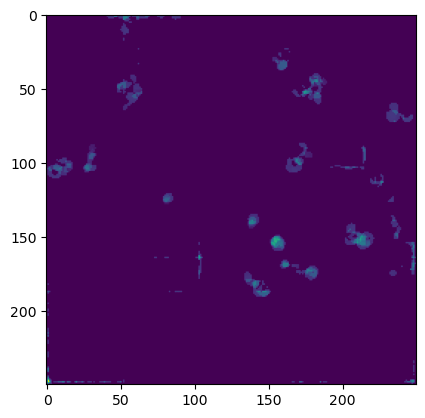

In [195]:
import matplotlib.pyplot as plt
sum_result = np.sum(result,2)
plt.imshow(sum_result)

In [183]:
mask,diff = post_group(masks_pred,diffusion_pred,250,250,21, 64, 0.2,3)
result = mask * diff